In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from statsmodels.stats.multitest import multipletests
from sklearn.linear_model import LinearRegression
from collections import defaultdict

data_root = '/Users/haileytrier/Downloads/Trier_et_al_2023_code/data/'
results_root = '/Users/haileytrier/Downloads/Trier_et_al_2023_code/results/'

/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_21557/2132515314.py:5: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr
/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_21557/2132515314.py:5: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr


## Pre-discovery phase: Test and plot correlations
With this analysis we aim to test whether activity in our ROIs is related to any of the behavioural measures linked with anxiety in our preprint study (https://osf.io/preprints/psyarxiv/v6u3y/). First we calculated for our fMRI participants the same behavioural measures computed in the preprint study (see the preprint, linked above, for details). The measures for each fMRI study participant are provided in /Trier_et_al_2023_code/data/Individual_CompoundMeasures_Imputed_fMRI-online-study-behav-measures.csv.

With these behavioural measures, we examine correlations with parameter estimates for threat level during switching to check in our current ROIs.

In [2]:
# Load behavioural measures. We focus here on behavioural measures associated with hypothesis 2B from the preprint study,
# because those behavioural measures were shown to be reliably related to anxiety in a large sample.
behav = pd.read_csv(data_root+'Individual_CompoundMeasures_Imputed_fMRI-online-study-behav-measures.csv')
behav = behav.loc[:,["ID","sticsa.trait.somatic.predicted.H2B","DEBRIEF.Q2","DEBRIEF.Q13","fullEpoch.perc.checkRelCheckPlusForage_Intercept","total.caught"]].copy()
behav = behav.reset_index(drop=True)
behav = behav.rename(columns={'sticsa.trait.somatic.predicted.H2B':'H2B combined','DEBRIEF.Q2':'Q2','DEBRIEF.Q13':'Q13','fullEpoch.perc.checkRelCheckPlusForage_Intercept':'% checks','total.caught':'Fish caught'})
behav = behav.melt(id_vars="ID")
behav = behav.rename(columns={'value':'behav_value','variable':'Behavior'})
behav

,ID,Behavior,behav_value
0,sub101,H2B combined,-0.213349
1,sub105,H2B combined,0.138716
2,sub103,H2B combined,-0.299003
3,sub204,H2B combined,0.216784
4,sub230,H2B combined,0.019326
...,...,...,...
140,sub224,Fish caught,0.655004
141,sub123,Fish caught,-0.984029
142,sub222,Fish caught,0.655004
143,sub121,Fish caught,0.655004


In [3]:
# Load extracted cope data for all contrasts & select contrasts of interest
brain = pd.read_csv(data_root+'ROI_stats_all_participants.csv')
brain = brain.loc[(brain.Phase=='pre') & (brain.Action=='firstCheck') & (brain.Regressor=='TimePressure'),:].copy()
brain = brain.rename(columns={'ParticipantID':'ID'})
brain = brain.rename(columns={'Value':'FC_threat_ROI_value'})

# Merge based on participant ID
brain = brain.reset_index(drop=True)
df = pd.merge(behav, brain.loc[:,['ID','ROI','FC_threat_ROI_value']], on='ID')
#df = pd.merge(df, count,on='ID')
df

,ID,Behavior,behav_value,ROI,FC_threat_ROI_value
0,sub105,H2B combined,0.138716,DRN,-0.3555
1,sub105,H2B combined,0.138716,HB,0.9228
2,sub105,H2B combined,0.138716,VTA,0.6776
3,sub105,H2B combined,0.138716,SN,0.4809
4,sub105,H2B combined,0.138716,ACC,1.9583
...,...,...,...,...,...
1260,sub228,Fish caught,-0.984029,Striatum,0.1898
1261,sub228,Fish caught,-0.984029,PAG,0.7827
1262,sub228,Fish caught,-0.984029,SC,1.1563
1263,sub228,Fish caught,-0.984029,Pulvinar,0.0901


In [4]:
# Compute stats
stats = pd.DataFrame(columns=["Behavior","ROI","Pearson r","Pearson p","Sig."])

roi_activity = defaultdict(list)
for roi in ['DRN', 'HB', 'VTA', 'SN']: # 'ACC', 'AI', 'Striatum', 'Precentral gyrus'
    for b in ['% checks']: # 'H2B combined','Q2','Q13','Fish caught'
        roi_activity[roi] = df.loc[(df.ROI==roi)&(df.Behavior==b),'FC_threat_ROI_value'].values
        r, p = pearsonr(df.loc[(df.ROI==roi)&(df.Behavior==b),'behav_value'], roi_activity[roi])
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else: 
            sig = 'n.s.'
        
        # if sig != 'n.s.':
        stats = pd.concat([stats,pd.DataFrame(data={"Behavior":[b],
                                          "ROI":[roi],
                                          "Pearson r":[r],
                                          "Pearson p":[p],
                                          "Sig.":[sig]})])
stats

/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_21557/418451398.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats = pd.concat([stats,pd.DataFrame(data={"Behavior":[b],


,Behavior,ROI,Pearson r,Pearson p,Sig.
0,% checks,DRN,0.515569,0.011804,*
0,% checks,HB,0.081583,0.711340,n.s.
0,% checks,VTA,0.388051,0.067294,n.s.
0,% checks,SN,0.423382,0.044109,*


In [5]:
# Conduct Bonferroni correction on p values
reject, pvals_corrected, alphacSidak, alphacBonf = multipletests(
    stats['Pearson p'].values, alpha=0.05, method='bonferroni', maxiter=1, is_sorted=False, returnsorted=False
)
pvals_corrected

array([0.04721437, 1.        , 0.26917637, 0.17643522])

In [6]:
# Test whether DRN variance is uniquely and specially related to checking variance
# Formula: check switch behavior = B0 + B1*VTA time pressure + B2*SN time pressure + B3*DRN time pressure + B4*HB time pressure
import statsmodels.api as sm

y = df.loc[(df.ROI==roi)&(df.Behavior=='% checks'),'behav_value']
x = np.array([
    roi_activity['DRN'],
    roi_activity['HB'],
    roi_activity['VTA'],
    #roi_activity['SN']
]).T
est = sm.OLS(y, x).fit()
print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:            behav_value   R-squared (uncentered):                   0.295
Model:                            OLS   Adj. R-squared (uncentered):              0.190
Method:                 Least Squares   F-statistic:                              2.796
Date:                Sun, 29 Sep 2024   Prob (F-statistic):                      0.0666
Time:                        21:33:35   Log-Likelihood:                         -17.401
No. Observations:                  23   AIC:                                      40.80
Df Residuals:                      20   BIC:                                      44.21
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

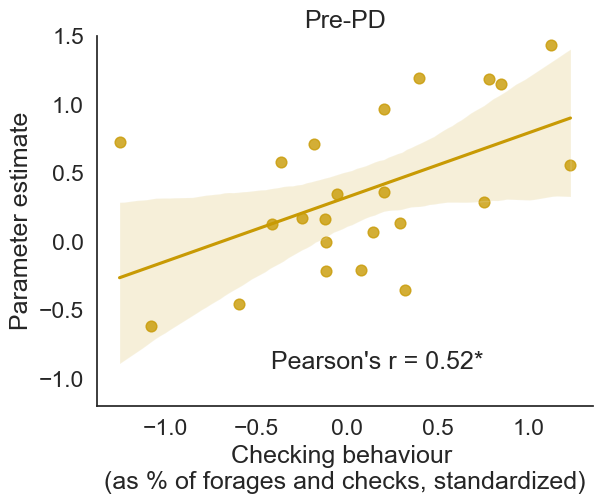

In [7]:
# Plot
sns.set(font_scale = 1.5)
sns.set_style("white")
ax = sns.regplot(x = "behav_value",
            y = "FC_threat_ROI_value",
            data = df.loc[(df.ROI=='DRN') & (df.Behavior=='% checks'),:],color='#c89a04', scatter_kws={'s':60})
ax.set_xlabel("Checking behaviour \n(as % of forages and checks, standardized)")
ax.set_ylabel("Parameter estimate")
ax.set_ylim(-1.2,1.5)
plt.text(0.35, .1, "Pearson's r = {:.2f}*".format(0.52), transform=ax.transAxes)
plt.title("Pre-PD")
sns.despine()

In [8]:
# stats.to_csv(results_root+'DRN_behavior_prePD_correlation_reproduced.csv')

## Post-discovery phase: Test and plot correlations
Test if any correlations between behaviours of interest (i.e., behaviours shown to be related to anxiety in our online study) and parameter estimates for threat level during switching to check replicate with post-discovery phase data. 

In [9]:
# Load extracted cope data from post-PD phase for all contrasts & select contrasts of interest
del brain
brain = pd.read_csv(data_root+'ROI_stats_all_participants.csv')
brain = brain.loc[(brain.Phase=='post') & (brain.Action=='firstCheck') & (brain.Regressor=='Proximity'),:].copy()
brain

,ParticipantID,ROI,Cope number,Phase,Action,Regressor,Value
2,sub103,DRN,3,post,firstCheck,Proximity,0.2873
25,sub103,HB,3,post,firstCheck,Proximity,0.5779
48,sub103,VTA,3,post,firstCheck,Proximity,-0.3785
71,sub103,SN,3,post,firstCheck,Proximity,0.1309
94,sub103,ACC,3,post,firstCheck,Proximity,0.5996
...,...,...,...,...,...,...,...
5706,sub232,Striatum,3,post,firstCheck,Proximity,-0.1479
5729,sub232,PAG,3,post,firstCheck,Proximity,0.2568
5752,sub232,SC,3,post,firstCheck,Proximity,0.6823
5775,sub232,Pulvinar,3,post,firstCheck,Proximity,-0.5097


In [10]:
# Reformat
brain = brain.rename(columns={'ParticipantID':'ID'})
brain = brain.rename(columns={'Value':'Checks_threat_ROI_value'})

# Merge based on participant ID
brain = brain.reset_index(drop=True)
df = pd.merge(behav, brain.loc[:,['ID','ROI','Checks_threat_ROI_value']], on='ID')
df

,ID,Behavior,behav_value,ROI,Checks_threat_ROI_value
0,sub105,H2B combined,0.138716,DRN,-0.2787
1,sub105,H2B combined,0.138716,HB,0.7176
2,sub105,H2B combined,0.138716,VTA,0.7445
3,sub105,H2B combined,0.138716,SN,0.5329
4,sub105,H2B combined,0.138716,ACC,0.7053
...,...,...,...,...,...
1260,sub228,Fish caught,-0.984029,Striatum,-0.2119
1261,sub228,Fish caught,-0.984029,PAG,-0.0605
1262,sub228,Fish caught,-0.984029,SC,0.2607
1263,sub228,Fish caught,-0.984029,Pulvinar,0.1152


In [11]:
# Compute stats
stats = pd.DataFrame(columns=["Behavior","ROI","Pearson r","Pearson p","Sig."])

for roi in ['DRN', 'HB', 'VTA','SN']:
    for b in ['% checks']:#,'Fish caught']:
        r, p = pearsonr(df.loc[(df.ROI==roi)&(df.Behavior==b),'behav_value'], df.loc[(df.ROI==roi)&(df.Behavior==b),'Checks_threat_ROI_value'])
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else: 
            sig = 'n.s.'
        
        #if sig != 'n.s.':
        stats = pd.concat([stats,pd.DataFrame(data={"Behavior":[b],
                                              "ROI":[roi],
                                              "Pearson r":[r],
                                              "Pearson p":[p],
                                              "Sig.":[sig]})])
stats

/var/folders/ck/bj1v04rj5k97nqvzmysnm2wr0000gn/T/ipykernel_21557/1303945852.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stats = pd.concat([stats,pd.DataFrame(data={"Behavior":[b],


,Behavior,ROI,Pearson r,Pearson p,Sig.
0,% checks,DRN,0.414333,0.049341,*
0,% checks,HB,0.123942,0.573139,n.s.
0,% checks,VTA,0.192305,0.379359,n.s.
0,% checks,SN,0.218655,0.316174,n.s.


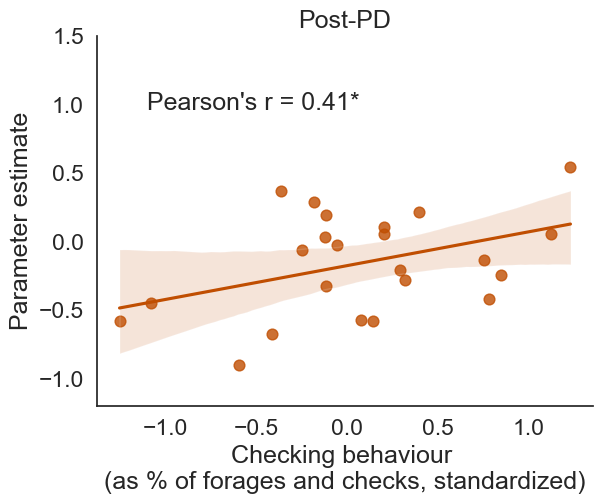

In [12]:
# Plot significant correlation between % checks and DRN parameter estimate for threat level (proximity) during switching to check
sns.set(font_scale = 1.5)
sns.set_style("white")
ax = sns.regplot(x = "behav_value",
            y = "Checks_threat_ROI_value",
            data = df.loc[(df.ROI=='DRN') & (df.Behavior=='% checks'),:],color='#c04e01', scatter_kws={'s':60})
ax.set_xlabel("Checking behaviour \n(as % of forages and checks, standardized)")
ax.set_ylabel("Parameter estimate")
ax.set_ylim(-1.2,1.5)
plt.text(0.1, .8, "Pearson's r = {:.2f}*".format(0.41), transform=ax.transAxes)
plt.title("Post-PD")
sns.despine()

In [ ]:
# stats.to_csv(results_root+'Post_disc_brain_behavior_correlation_stats_reproduced.csv')